In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

from Features import *



In [51]:
df=pd.read_csv('ReadyData/EURUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)

In [52]:

df = df[:10000]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2020-01-02 00:15:00 to 2020-05-27 07:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       10000 non-null  float64
 1   high       10000 non-null  float64
 2   low        10000 non-null  float64
 3   close      10000 non-null  float64
 4   volume     10000 non-null  int64  
 5   low_time   9999 non-null   object 
 6   high_time  9999 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 625.0+ KB


# Features and strategy logic

In [53]:
df['change'] = df.close.pct_change()
df = rolling_adf(df, 'close', 30)
df = rsi(df, 'close', 14)
df = calculate_up_down(df)
df = update_count_columns(df)
df = features_counting(df,20,2)

df = atr(df,5)
df['hour'] = df.index.hour
df.tail()



,open,high,low,close,volume,low_time,high_time,change,rolling_adf_stat,rolling_p_value,...,spike_up,spike_down,spike_up_mean,spike_up_std,spike_up_band,spike_down_mean,spike_down_std,spike_down_band,ATR,hour
time,,,,,,,,,,,,,,,,,,,,,
2020-05-27 06:00:00,1.09598,1.09628,1.09593,1.09609,270,2020-05-27 06:09:00,2020-05-27 06:06:00,0.000100,2.023907,0.998703,...,0.000242,0.00000,0.000074,0.000132,0.000339,0.000185,0.000265,0.000714,0.000532,6
2020-05-27 06:15:00,1.09608,1.09626,1.09602,1.09614,206,2020-05-27 06:19:00,2020-05-27 06:20:00,0.000046,-1.753398,0.403831,...,0.000176,0.00000,0.000068,0.000124,0.000316,0.000185,0.000265,0.000714,0.000462,6
2020-05-27 06:30:00,1.09614,1.09632,1.09590,1.09623,233,2020-05-27 06:33:00,2020-05-27 06:37:00,0.000082,-0.802262,0.818457,...,0.000153,0.00000,0.000076,0.000124,0.000324,0.000185,0.000265,0.000714,0.000428,6
2020-05-27 06:45:00,1.09623,1.09641,1.09614,1.09621,181,2020-05-27 06:45:00,2020-05-27 06:47:00,-0.000018,-0.758039,0.831138,...,0.000000,0.00000,0.000075,0.000124,0.000324,0.000185,0.000265,0.000714,0.000368,6
2020-05-27 07:00:00,1.09621,1.09628,1.09571,1.09589,252,2020-05-27 07:04:00,2020-05-27 07:00:00,-0.000292,-0.871135,0.797329,...,0.000000,0.00031,0.000074,0.000125,0.000324,0.000200,0.000262,0.000725,0.000370,7


In [45]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'low_time', 'high_time',
       'change', 'rolling_adf_stat', 'rolling_p_value',
       'rolling_critical_value', 'signal', 'RSI', 'up', 'down', 'count_up',
       'count_down', 'spike_up', 'spike_down', 'spike_up_mean', 'spike_up_std',
       'spike_up_band', 'spike_down_mean', 'spike_down_std', 'spike_down_band',
       'ATR', 'hour'],
      dtype='object')

# Backtest

In [46]:
position = None
cumulative_profit = 0
trades = []
cost = 0.0001
trailing = False

for i in range(1, len(df)):
    prev_row = df.iloc[i - 1]
    current_row = df.iloc[i]
    trading_time = current_row['hour'] > 9 and current_row['hour'] < 20
    
    # Slightly relaxed Long Entry Condition
    long_entry =  current_row['spike_down_band'] < current_row['spike_down'] and trading_time and current_row['signal'] > 0 #and current_row['RSI'] < 30
    short_entry = current_row['spike_up_band'] < current_row['spike_up'] and trading_time and current_row['signal'] > 0 #and current_row['RSI'] > 70


    #long_exit = current_row['Close'] > current_row['MA']
    #short_exit =  current_row['Close'] < current_row['MA']


    # Check for long entry condition
    if position is None and long_entry:
        entry_price = current_row['close']+cost
        entry_time = df.index[i]  
        tp_price = entry_price + current_row['ATR'] * 5
        sl_price = entry_price - current_row['ATR'] * 3
        position = 'long'
    
    elif trailing == True and position == 'long' and not (current_row['low'] < sl_price or current_row['high'] > tp_price) and current_row['close'] > entry_price:
        sl_price = current_row['close'] - current_row['ATR'] * 3 


    # Check for long exit condition
    elif position == 'long' and (current_row['low'] < sl_price or current_row['high'] > tp_price):
        if current_row['low'] < sl_price and current_row['high'] > tp_price:
            if current_row['low_time'] < current_row['high_time']:
                exit_price = sl_price
            elif current_row['high_time'] < current_row['low_time']:
                exit_price = tp_price
        elif current_row['high'] > tp_price:
            exit_price = tp_price
        elif current_row['low'] < sl_price:
            exit_price = sl_price
        # else if I have exit condition
        #else:
            #exit_price = current_row['close']

        exit_time = df.index[i]  # Capturing the exit time
        pnl = exit_price - entry_price
        cumulative_profit += pnl
        trades.append({'Type': 'Long', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None

    # Check for short entry condition
    elif position is None and short_entry:
        entry_price = current_row['close'] - cost
        entry_time = df.index[i] 
        tp_price = entry_price - current_row['ATR'] * 5
        sl_price = entry_price + current_row['ATR'] * 3
        position = 'short'

    elif trailing == True and  position == 'short' and not (current_row['high'] > sl_price or current_row['low'] < tp_price) and current_row['close'] < entry_price :
        sl_price = current_row['close'] + current_row['ATR'] * 3



    # Check for short exit condition
    elif position == 'short' and (current_row['high'] > sl_price or current_row['low'] < tp_price):
        if current_row['high'] > sl_price and current_row['low'] < tp_price:
            if current_row['high_time'] < current_row['low_time']:
                exit_price = sl_price
            elif current_row['low_time'] < current_row['high_time']:
                exit_price = tp_price
        elif current_row['high'] > sl_price:
            exit_price = sl_price
        elif current_row['low'] < tp_price:
            exit_price = tp_price
        # else if I have exit condition
        #else:
           #exit_price = current_row['close']
 
        exit_time = df.index[i]  # Capturing the exit time
        pnl = entry_price - exit_price
        cumulative_profit += pnl
        trades.append({'Type': 'Short', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None
        
# Convert the list of dictionaries to a DataFrame
history_book = pd.DataFrame(trades)


In [47]:
history_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Type               359 non-null    object        
 1   Entry Price        359 non-null    float64       
 2   Exit Price         359 non-null    float64       
 3   Entry Time         359 non-null    datetime64[ns]
 4   Exit Time          359 non-null    datetime64[ns]
 5   PnL                359 non-null    float64       
 6   Cumulative Profit  359 non-null    float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 19.8+ KB


In [48]:
calculate_performance_metrics(history_book)

{'Start Time': '2020-01-02 11:45:00',
 'End Time': '2023-12-13 21:00:00',
 'Win Rate (%)': 0.37,
 'Maximum Drawdown (pips)': 0.1758,
 'Average Drawdown (pips)': 0.0814,
 'Maximum Drawdown Duration': '1322 days 02:15:00',
 'Average Drawdown Duration': '233 days 23:02:30',
 'Total Number of Trades': 359,
 'Buy Count': 182,
 'Sell Count': 177,
 'Total Profit (pips)': -24.74,
 'Average Time in Trade': '1 days 04:33:00',
 'Average win': 0.006,
 'Average loss': -0.0035}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


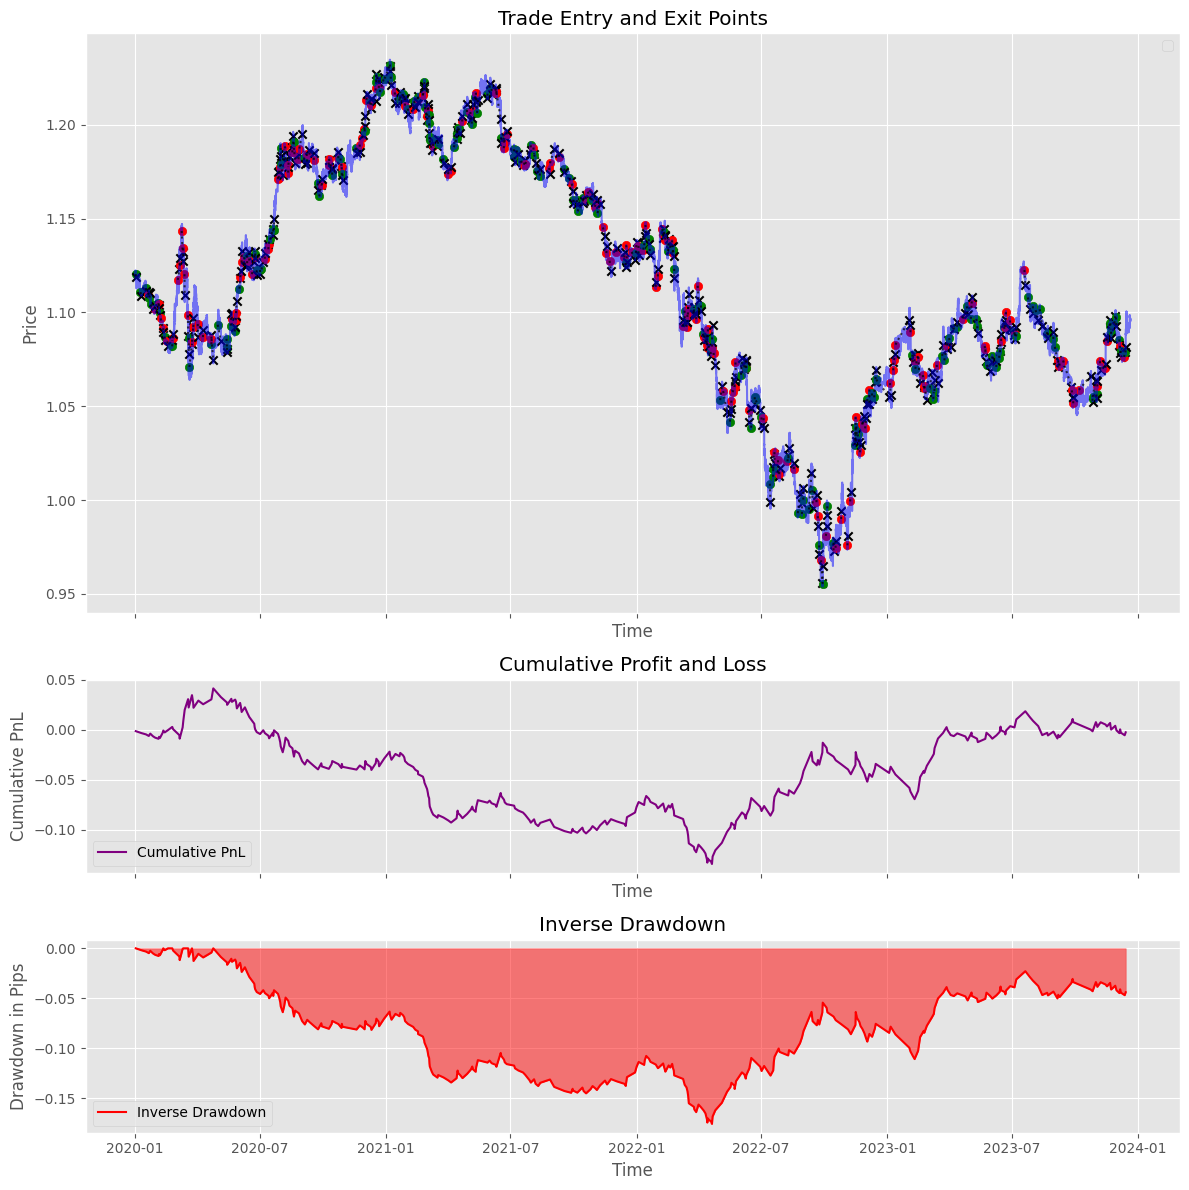

In [49]:
plot_trades(history_book,df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


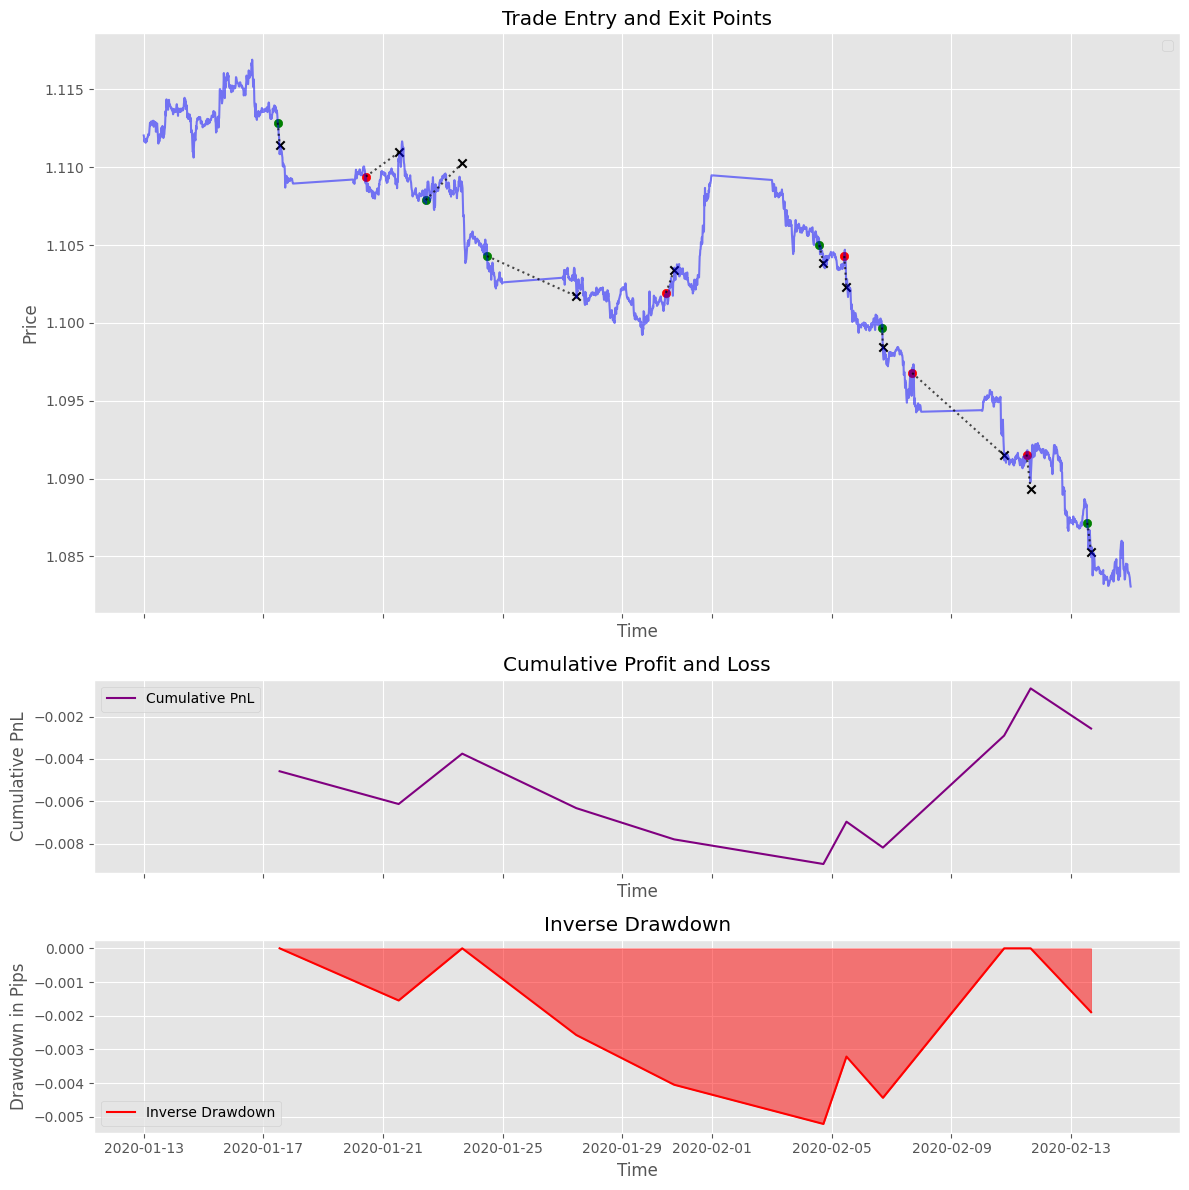

In [41]:
plot_trades(history_book,df,'2020-01-11','2020-02-15')

In [30]:
history_book

,Type,Entry Price,Exit Price,Entry Time,Exit Time,PnL,Cumulative Profit
0,Long,1.10858,1.11157,2020-01-20 11:00:00,2020-01-21 15:15:00,0.00299,0.00299
1,Short,1.10429,1.10229,2020-02-05 10:00:00,2020-02-05 11:45:00,0.00200,0.00499
2,Long,1.09334,1.08990,2020-02-10 15:45:00,2020-02-11 15:15:00,-0.00344,0.00155
3,Short,1.08636,1.09291,2020-02-25 17:45:00,2020-02-27 10:00:00,-0.00655,-0.00500
4,Short,1.11735,1.12728,2020-03-03 17:00:00,2020-03-06 10:30:00,-0.00993,-0.01493
...,...,...,...,...,...,...,...
57,Long,1.08898,1.08463,2023-08-22 13:15:00,2023-08-22 16:45:00,-0.00435,0.02776
58,Short,1.06282,1.05589,2023-10-11 16:45:00,2023-10-12 16:30:00,0.00693,0.03469
59,Short,1.05843,1.06245,2023-10-23 10:15:00,2023-10-23 17:15:00,-0.00402,0.03067
60,Short,1.08486,1.08800,2023-11-16 10:15:00,2023-11-16 15:45:00,-0.00314,0.02753
